# Problem 3: Permutation equivariant neural networks


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Add, BatchNormalization, ReLU, Reshape, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import History
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model


In [ ]:
xtrain = pd.read_csv('/content/sample_data/xtrain-2.csv').values
xtest = pd.read_csv('/content/sample_data/xtest-2.csv').values
ytrain = pd.read_csv('/content/sample_data/ytrain-2.csv').values
ytest = pd.read_csv('/content/sample_data/ytest-2.csv').values

In [ ]:
df_ytrain = pd.DataFrame(ytrain)
df_ytest = pd.DataFrame(ytest)
df_xtrain = pd.DataFrame(xtrain)
df_xtest = pd.DataFrame(xtest)

In [ ]:
ytrain = df_ytrain.iloc[:, 1:].values
ytest = df_ytest.iloc[:, 1:].values
xtrain = df_xtrain.iloc[:, 1:].values
xtest = df_xtest.iloc[:, 1:].values

In [ ]:
xtrain = xtrain.reshape(-1, 5, 3)
xtest = xtest.reshape(-1, 5, 3)

n_features = xtrain.shape[1:]
n_classes = ytrain.shape[1]

## 0.1 Neural Network Implementation  



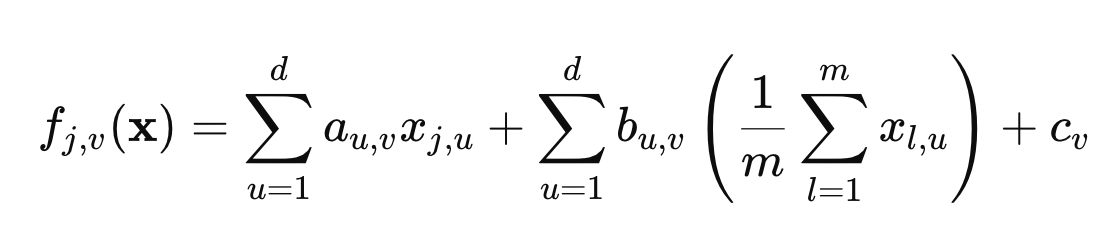

To implement a permutation equivariant function, I use two convolutional layers and a global average pooling layer.

**For the first summation term**

$$ \sum_{u=1}^{d} a_{u,v} x_{j,u} + c_v$$

I employ a Conv1D layer with a kernel size of 1 to ensure that each row is processed independently, preserving its unique feature representation. This is to maintain equivariance within each row, ensuring that the transformation remains consistent regardless of row order.

Because Conv1D inherently maintains row-wise processing, the convolution operation sums over columns  d  with learnable parameters  a , as presented in the equation. This translation equivariance property of convolutional layers ensures that shifting or reordering rows does not mix their values—each row remains distinct while still undergoing feature transformation. Therefore, I take advantage of this equivariance property, which is fundamental to convolutional layers: even if an object’s position shifts within an image (or a feature moves in a sequence), the same pattern will still be detected at its new location. Additionally, I ensure this conv layer use bais (bias=True) for each feature outcome.


**Second summation term**


$$ \sum_{u=1}^{d} b_{u,v} \left( \frac{1}{m} \sum_{l=1}^{m} x_{l,u} \right) $$


I employ a global average pooling layer to compute features of each column across all rows. A mean does not depend on row order, swapping rows does not change the mean. This makes architecture invariant to the order of input. In practice, I implement this using the GlobalAveragePooling1D layer, which computes the mean across the temporal dimension (rows) of the input tensor. Following this pooling, I apply a convolutional layer. Lastly, I exclude the bias term in this convolutional layer due to the invariant nature of the global features.


Additionally, I use Conv1D instead of using fully-connected layer as it may break the permutation-equivariant property unless the layer is explicitly designed to be permutation-invariant (e.g., via global pooling).

Conv1D operates along the temporal dimension (steps). Since each step (row) in the input represents a class prediction, using Conv1D with kernel_size=1 is equivalent to applying a Dense layer to each step independently.

I used softmax activation to enforce a probability distribution over the output classes, which is appropriate for multi-class classification. However, the task requires me to use Mean Squared Error (MSE) loss, which is more common for regression tasks. This could potentially cause ineffective loss calculation. Using categorical crossentropy instead resulted in a slightly lower validation loss (1.3966), although I did not include this outcome in this paper.

In [ ]:
def build_permutation_equivariance(input_shape=(5, 3), w=2, L=5):
    input = Input(shape=input_shape)
    x = input
    for _ in range(L - 1):
        conv1 = Conv1D(w, kernel_size=1, use_bias=True)(x)
        avg = GlobalAveragePooling1D()(x)
        avg_reshaped = Reshape((1, avg.shape[-1]))(avg)
        conv2 = Conv1D(w, kernel_size=1, use_bias=False)(avg_reshaped)

        combined = Add()([conv1, conv2])
        norm = BatchNormalization()(combined)
        x = ReLU()(norm)

    conv_logits = Conv1D(1, kernel_size=1, use_bias=True)(x)
    flatten = Flatten()(conv_logits)
    output = Activation('softmax')(flatten)

    model = Model(inputs=input, outputs=output)
    return model

def training_testing(L, w):
    model = build_permutation_equivariance(w=w, L=L)
    model.compile(optimizer=Adam(learning_rate=1e-4, epsilon=1e-3), loss=MeanSquaredError())

    history = model.fit(xtrain, ytrain, validation_split=0.1, batch_size=300, epochs=100, verbose=1)

    # Compute mse
    y_pred = model.predict(xtest)
    test_mse = mean_squared_error(ytest, y_pred)

    return history, test_mse

# Different (L, w) combination
combination = [(5, 2), (2,10), (2,100), (2,200), (3,5), (3,10), (3,100), (3,200)]
combination_name = ["L:5 w:2", "L:2 w:10", "L:2 w:100",  "L:2 w:200",  "L:3 w:5", "L:3 w:100", "L:3 w:200"]
hist_loss = []
hist_loss_val = []
test_mse = []

start = time.time()

for (L, w), name in zip(combination, combination_name):
    print("-----------------------------")
    print("Doing %s combination" %str(name))
    print("-----------------------------")

    history, mse = training_testing(L, w)
    hist_loss.append(history.history['loss'])
    hist_loss_val.append(history.history['val_loss'])
    test_mse.append(mse)

end = time.time()
time_nn = (end-start) / 60
print('minutes to run: ', time_nn)

-----------------------------
Doing L:5 w:2 combination
-----------------------------
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1620 - val_loss: 0.1610
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1608 - val_loss: 0.1605
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1604 - val_loss: 0.1603
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1603 - val_loss: 0.1602
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1602 - val_loss: 0.1601
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1601 - val_loss: 0.1601
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1601 - val_loss: 0.1601
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1601 - val_loss: 0.1600
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1601 - val_loss: 0.1600
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1601 - val_loss: 0.1600
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━

In [ ]:
for name, mse in zip(combination_name, test_mse):
    print("MSE of ", name, "=", round(mse, 3))

MSE of  L:5 w:2 = 0.16
MSE of  L:2 w:10 = 0.157
MSE of  L:2 w:100 = 0.155
MSE of  L:2 w:200 = 0.155
MSE of  L:3 w:5 = 0.148
MSE of  L:3 w:100 = 0.149
MSE of  L:3 w:200 = 0.147


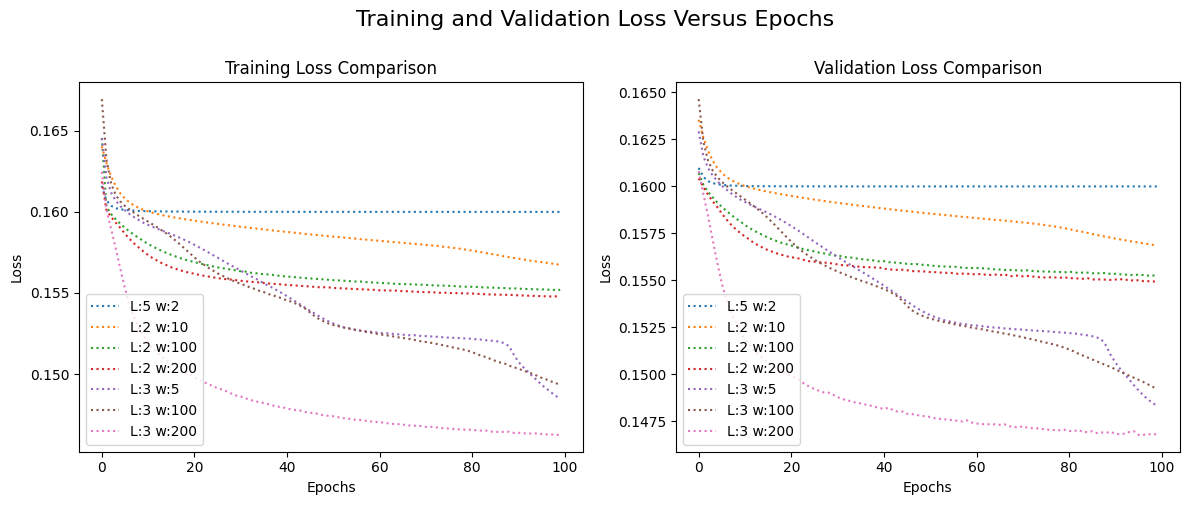

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training loss
for name, loss in zip(combination_name, hist_loss):
    ax1.plot(loss, label=name, linestyle='dotted')
ax1.set_title("Training Loss Comparison")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot validation loss
for name, val_loss in zip(combination_name, hist_loss_val):
    ax2.plot(val_loss, label=name, linestyle='dotted')
ax2.set_title("Validation Loss Comparison")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

# Set the overall title
fig.suptitle("Training and Validation Loss Versus Epochs", fontsize=16, y=1.00)
plt.show()

The architecture with 5 layers and 2 kernels consistently underperforms across training and validation. Given that this configuration has the fewest kernels, it suggests that a network with fewer features struggles to learn general patterns effectively, making it harder to reduce loss. Likewise, the network with greatest number of layers(3) and features(200) dramatically reduces its training and validation loss.

Architectures with two layers and increasing kernel counts (w:10, w:100, w:200) exhibit incremental improvements, suggesting that in shallower networks, a higher kernel count can partially compensate for limited depth. However, their validation loss likely plateaus earlier than deeper models like L:3 w:200, as two layers may be insufficient to capture high-level feature representations. Interestingly, L:3 w:5 and L:3 w:100 occupy a middle ground in performance. Given that L:5 w:2 significantly underperforms, **this may suggest that beyond a certain depth threshold (in this case, L:3), the number of kernels may become slightly less critical, potentially indicating diminishing returns in feature extraction efficiency.**

While deeper networks with more kernels generally perform better, they also introduce significant computational overhead. Architectures such as L:3 w:200, while highly effective in reducing loss, , require greater GPU resources, which may not be practical for all applications. In contrast, L:3 w:5 achieves similar performance with far fewer parameters, offering a more computationally efficient alternative. Meanwhile, L:5 w:2 illustrates that depth alone is not a sufficient factor in improving model performance—without an adequate kernel count, deeper architectures may fail to learn effectively.

Therefore, it is crucial to balance architecture complexity and computational efficiency. **While over-parameterised networks may achieve lower loss, an optimal combination of depth and width can offer comparable performance with reduced training time and resource consumption, avoiding diminishing returns.**